# Convolutional Neural Network for Hotspot Detection on ICCAD2012

### Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import time

In [3]:
tf.__version__

'2.9.1'

### Global Parameters

In [4]:
SIZE = 64
# Image Parameters in the future can be added to the channels
CHANNELS = 3
DROPOUT_RATE = 0.4
BATCH_SIZE = 32
CLASSES = {'NHS':0, 'HS':1}

## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [5]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)
training_set = train_datagen.flow_from_directory(directory = 'iccad1/train',
                                                 target_size = (SIZE, SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 classes = CLASSES,
                                                 class_mode = 'binary',
                                                 shuffle = True,
                                                 seed = 42
                                                )

Found 439 images belonging to 2 classes.


### Preprocessing the Test set

In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(directory = 'iccad1/test',
                                            target_size = (SIZE, SIZE),
                                            batch_size = BATCH_SIZE,
                                            classes = CLASSES,
                                            class_mode = 'binary',
                                            shuffle = True,
                                            seed = 42
                                            )

Found 4905 images belonging to 2 classes.


## Part 2 - Building the CNN

### Deploy ML model on GPUs using mirrored strategy

In [43]:
# tensorflow-gpu should be correctly updated, otherwise the strategy will not work
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0
Num GPUs Available:  0


In [14]:
# The code below may have to be adjusted in different machines.
mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/gpu:0","/gpu:1"],
                                                   cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [16]:
with mirrored_strategy.scope():
    # Initialising the CNN
    cnn = tf.keras.models.Sequential()

    # Convolutional & Pooling Layers
    cnn.add(tf.keras.layers.Conv2D(filters=4, kernel_size=3, activation='relu', input_shape=[SIZE, SIZE, CHANNELS]))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    # Flattening
    cnn.add(tf.keras.layers.Flatten())

    # Full Connection Layers
    cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))
    cnn.add(tf.keras.layers.Dropout(DROPOUT_RATE))
    cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
    cnn.add(tf.keras.layers.Dropout(DROPOUT_RATE))

    # Output Layer
    cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    # For multiclass classification, softmax should be used as activation function.
    #cnn.add(tf.keras.layers.Dense(units=n, activation='softmax'))

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

### Model Summary

In [17]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 4)         112       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 4)        16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 8)         296       
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 8)        32        
 hNormalization)                                                 
                                                        

## Part 3 - Training the CNN

### Compiling the CNN

In [18]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99)
# opt = 'adam'  #This optimizer can be used for comparison
cnn.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
# For multiclass classification:
# cnn.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

In [19]:
start_time = time.time()
history = cnn.fit(x = training_set, validation_data = test_set, epochs = 16)
end_time = time.time()
print("\n********Time used for training: ", end_time - start_time)

Epoch 1/16
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

### Plot the training and validation accuracy and loss at each epoch

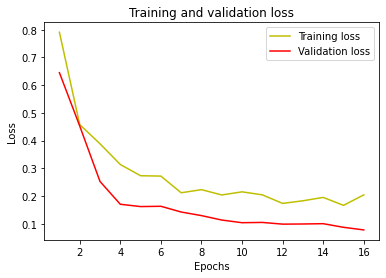

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

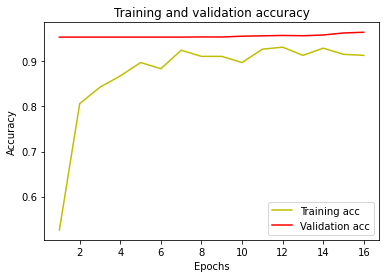

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Save CNN model

In [22]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
cnn.save('cnn.h5')

# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('cnn.h5')
# Show the model architecture
# new_model.summary()

In [23]:
# https://youtu.be/NVY0FucNRU4
# Save only weights
cnn.save_weights('cnn_weights.h5')

# cnn.load_weights('cnn_weights.h5')

# Save only architecture
jason_string = cnn.to_json()
with open("cnn_model.json", "w") as f:
    f.write(jason_string)

with open("cnn_model.json", "r") as f:
    loaded_json_string = f.read()
    
#new_model = keras.model.model_from_json(loaded_json_string)
#print(new_model.summary())


## Part 4 - Making a single prediction

In [24]:
def single_predict(fileName):
    path = 'iccad1/single_prediction/' + fileName + '.png'
    test_image = image.load_img(path, target_size = (SIZE, SIZE))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    #print(test_image)
    result = cnn.predict(test_image/255.0)
    print(result)
    training_set.class_indices
    print(training_set.class_indices)
    if result[0][0] > 0.5:
      prediction = 'HS'
    else:
      prediction = 'NHS'

    print(prediction)
    
def showPNG(fileName):
    path = 'iccad1/single_prediction/' + fileName + '.png'
    display(Image(path, width = 200, height = 200))

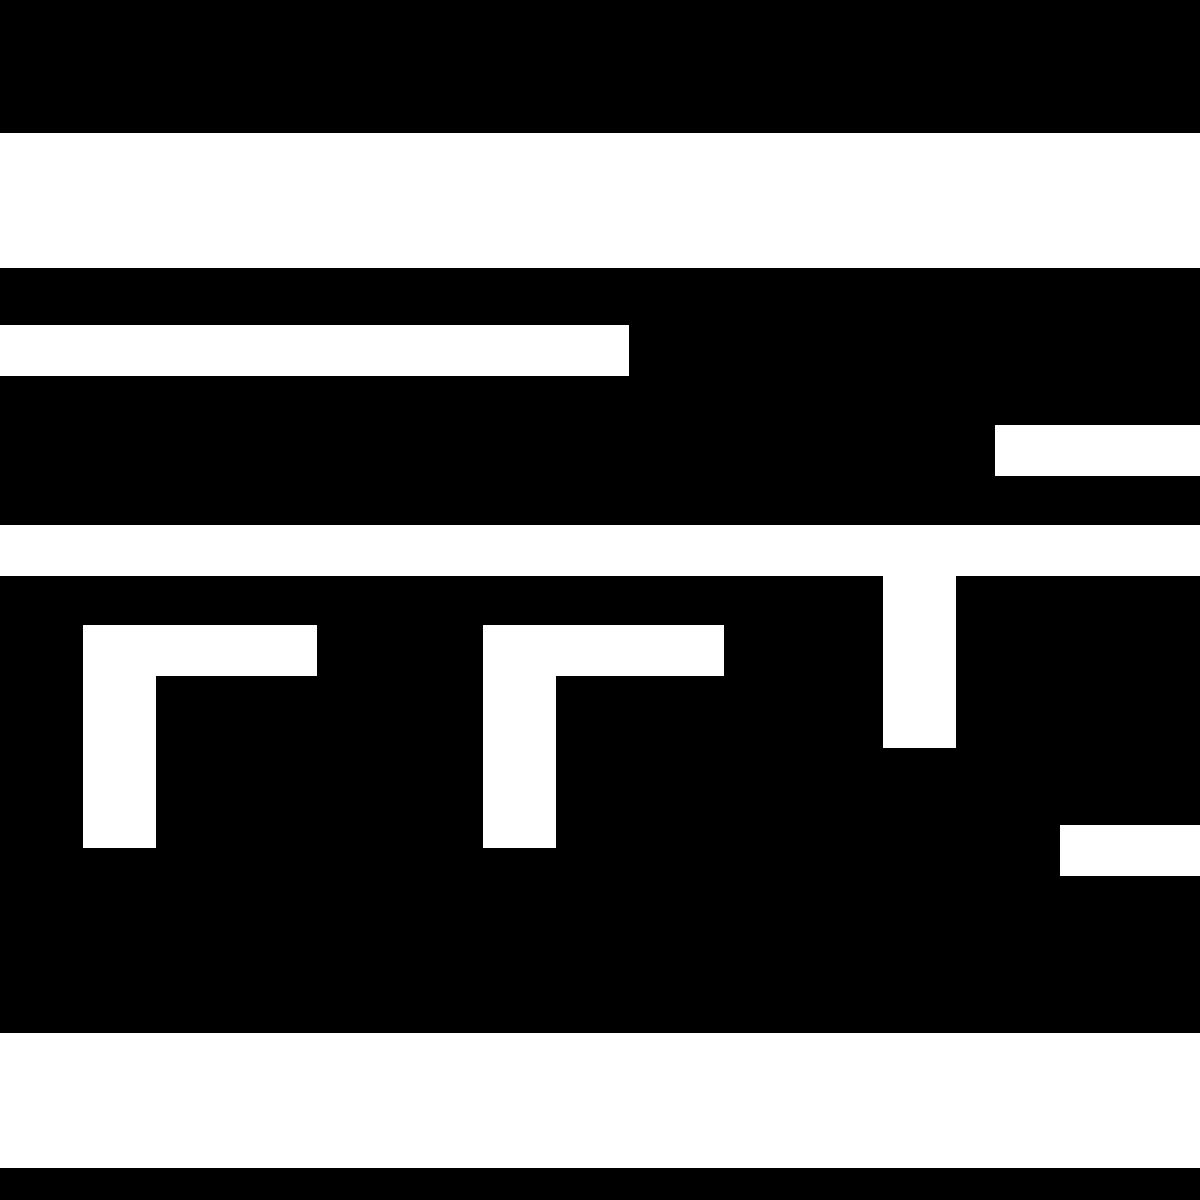

In [25]:
showPNG('train_HS12')

In [26]:
single_predict('train_HS12')

1/1 [==============================] - 1s 1s/step
[[0.6785065]]
{'NHS': 0, 'HS': 1}
HS


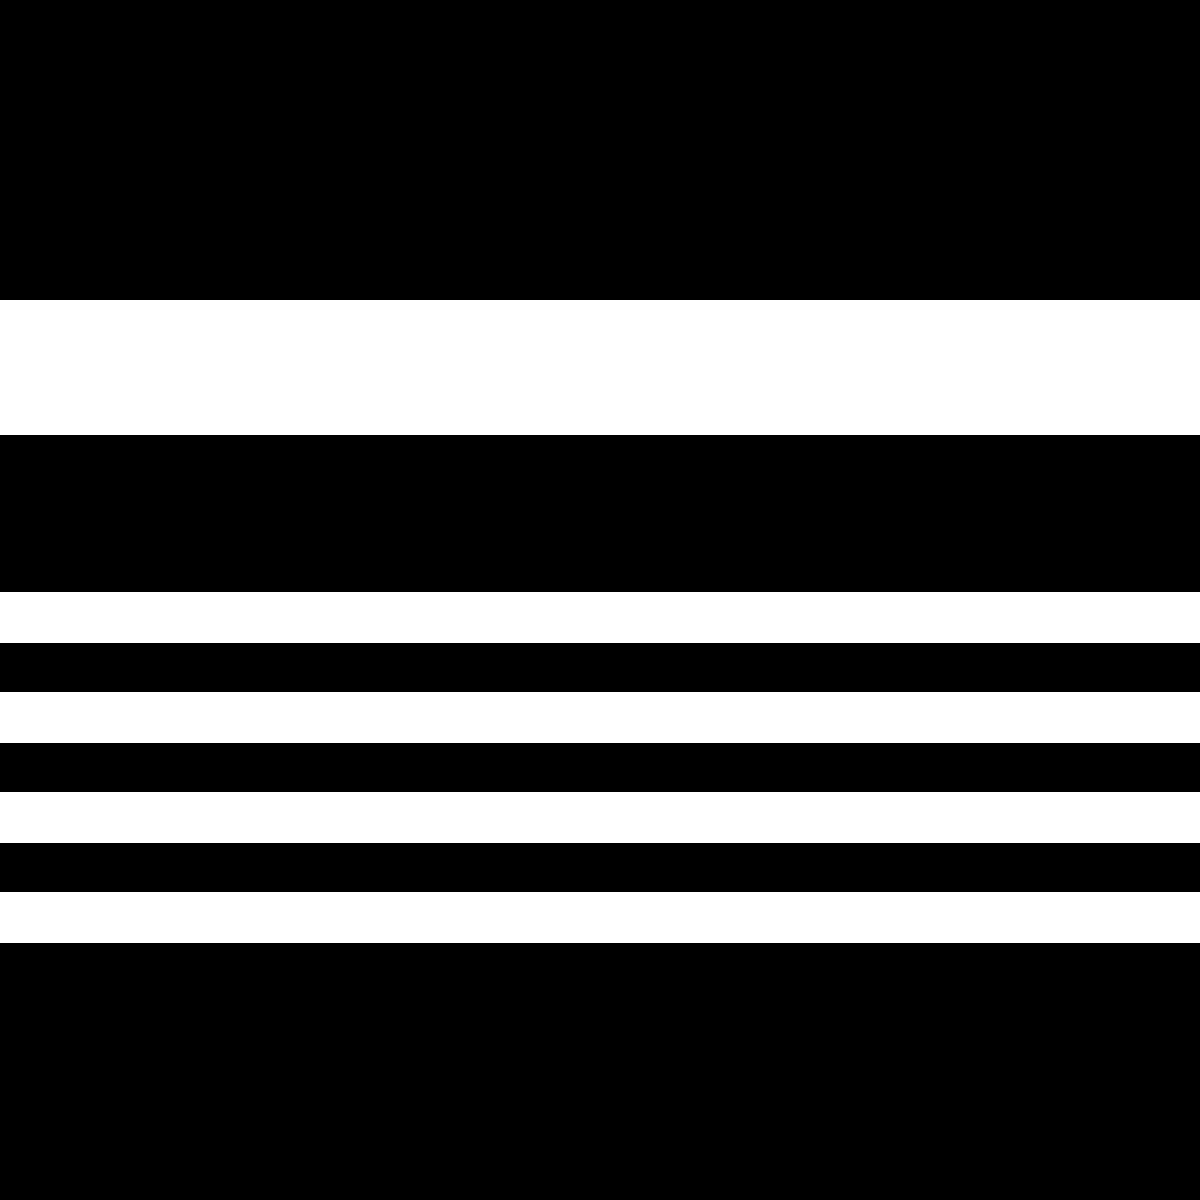

In [27]:
showPNG('train_NHS100')

In [28]:
single_predict('train_NHS100')

1/1 [==============================] - 0s 70ms/step
[[0.00025769]]
{'NHS': 0, 'HS': 1}
NHS


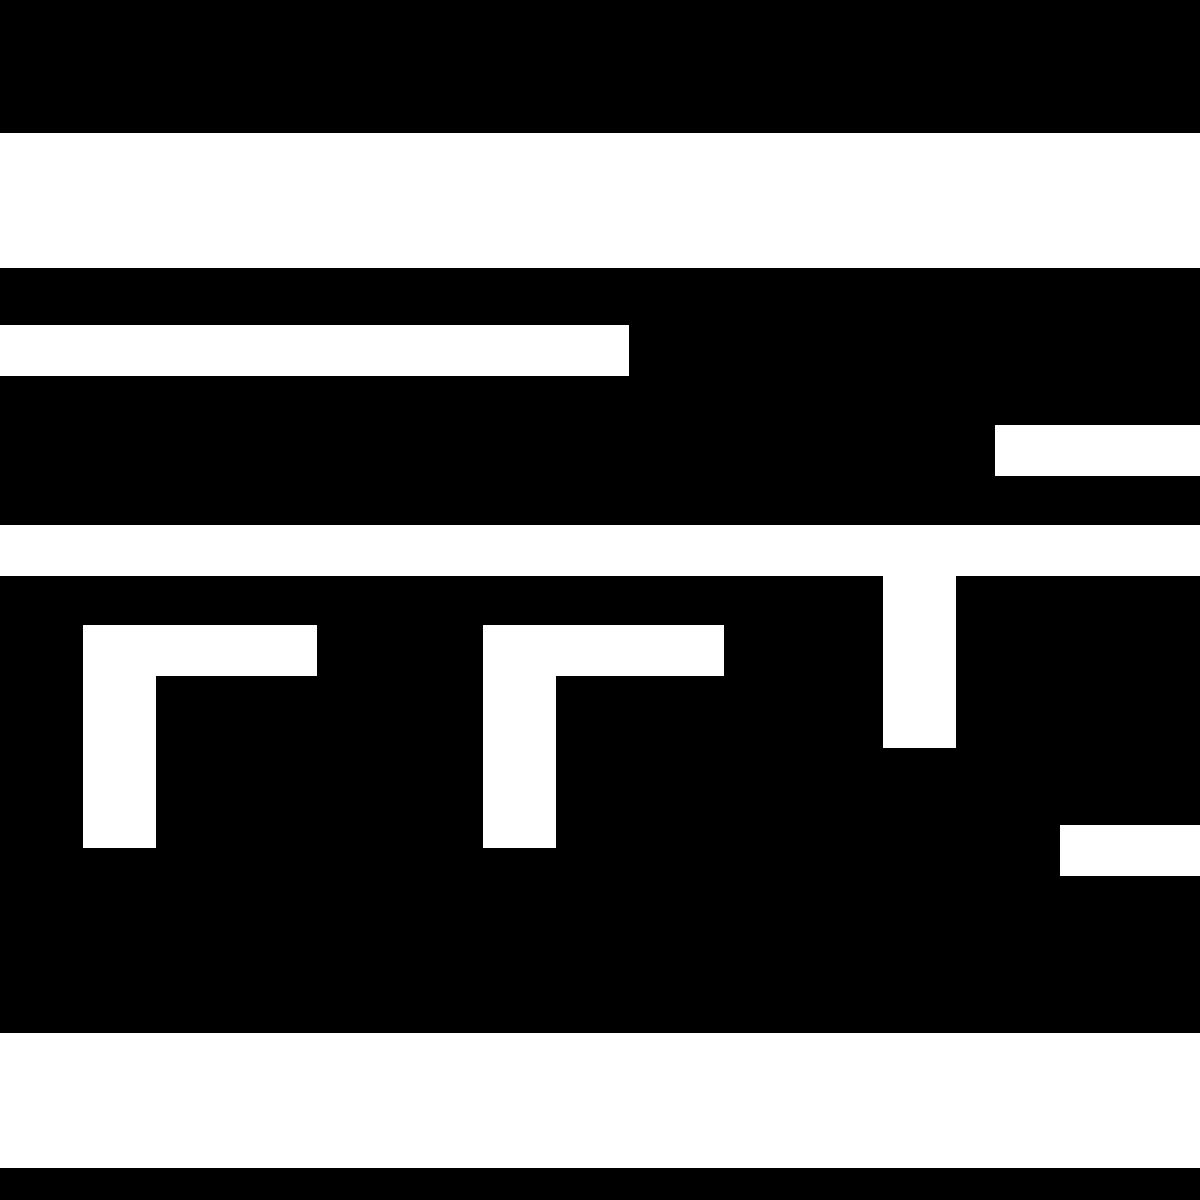

In [29]:
showPNG('test_HS12')

In [30]:
single_predict('test_HS12')

1/1 [==============================] - 0s 64ms/step
[[0.6785065]]
{'NHS': 0, 'HS': 1}
HS


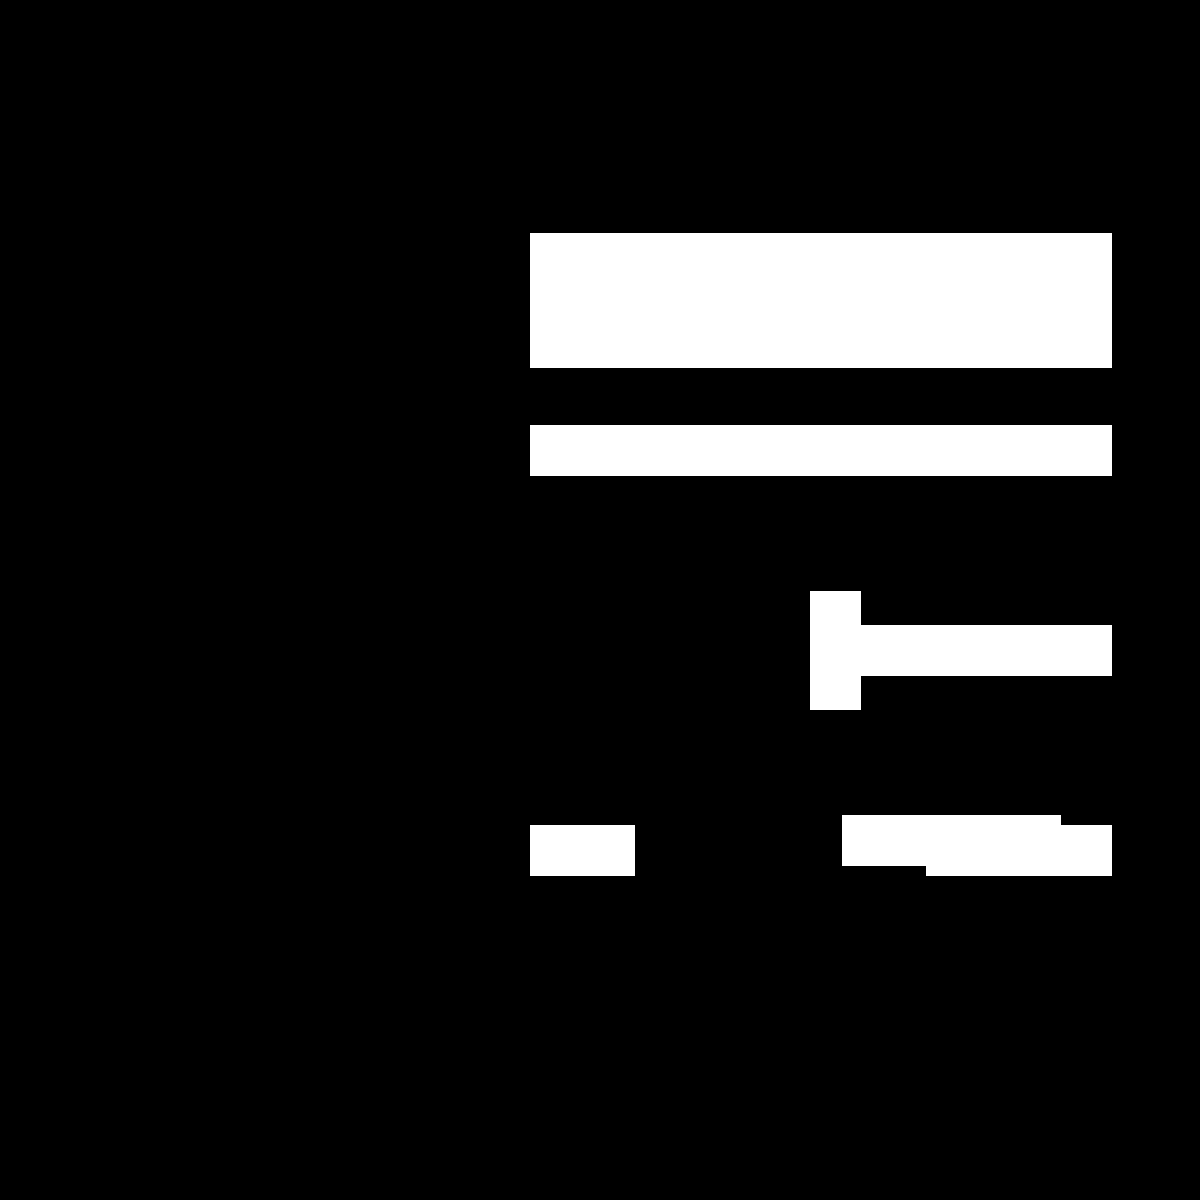

In [31]:
showPNG('test_NHS133.png1')

In [32]:
single_predict('test_NHS133.png1')

1/1 [==============================] - 0s 66ms/step
[[0.21462864]]
{'NHS': 0, 'HS': 1}
NHS


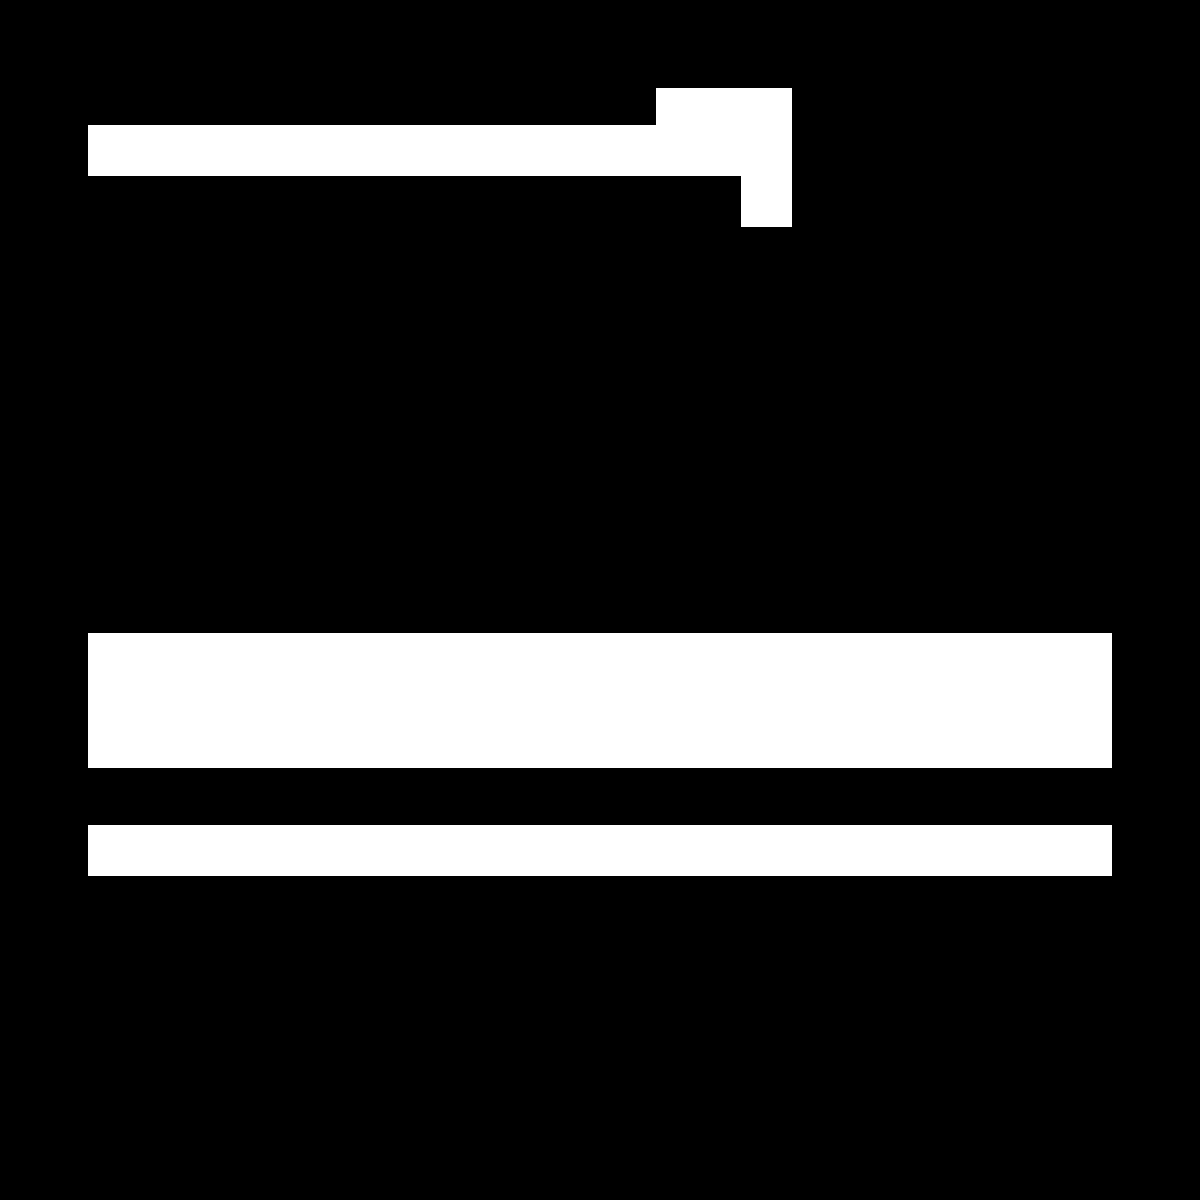

In [33]:
showPNG('test_NHS108.png9')

In [34]:
single_predict('test_NHS108.png9')

1/1 [==============================] - 0s 61ms/step
[[9.177511e-06]]
{'NHS': 0, 'HS': 1}
NHS


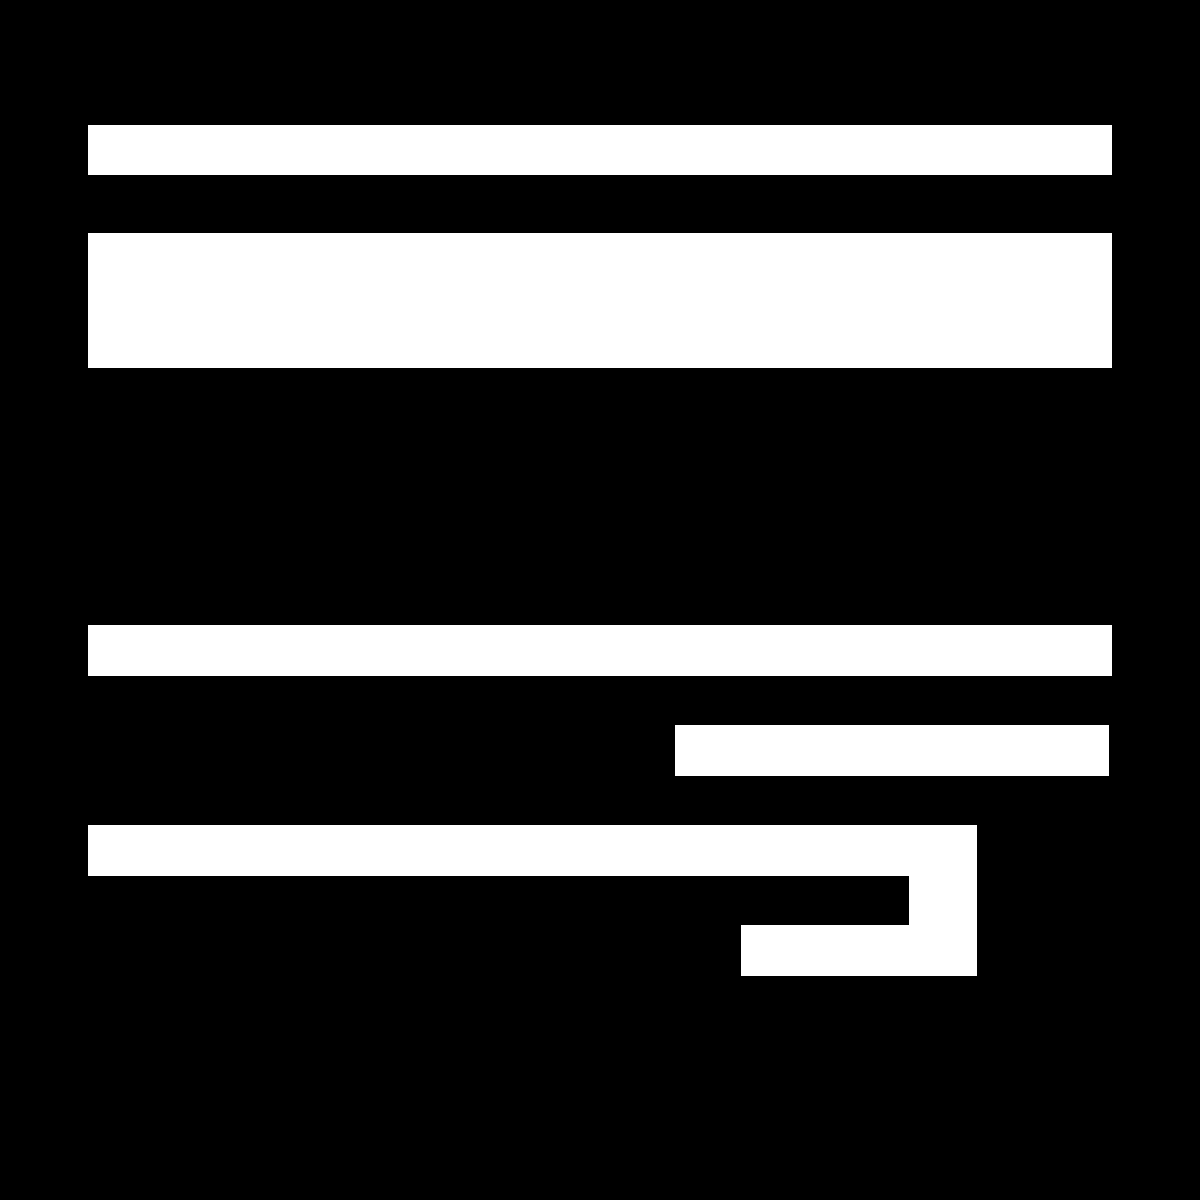

In [35]:
showPNG('test_NHS10.png2')

In [36]:
single_predict('test_NHS10.png2')

1/1 [==============================] - 0s 62ms/step
[[8.1661245e-05]]
{'NHS': 0, 'HS': 1}
NHS
